### ITD
En este dataset tenemos fotos tomadas con 10 cámaras diferentes a diferentes telas. De cada cámara tenemos una parte de las fotos para train, en las que solamente hay fotos de telas en buen estado. Y otra parte para test, en las que hay fotos de telas en buen estado y dañadas.
El objetivo es entrenar el modelo solo con las fotos de train (tela en buen estado) y poder predecir si una foto de test es una tela en buen estado ($y_{test}=0$) o dañada ($y_{test}=1$).

## Leer datos todos juntos

Leemos mezclando test y train, y luego particioanremos todos los datos en train, val y test

In [4]:
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

def cargar_dataset_imagenes_raw(root_path, image_size=(64, 64)):
    """
    Lee las imágenes y las devuelve en formato (N, Alto, Ancho)
    con valores 0-255 (Enteros). Ideal para LBP.
    """
    X_list = []
    y_list = []
    
    root = Path(root_path)
    print(f"📂 Escaneando imágenes en: {root.absolute()} ...")
    
    if not root.exists():
        print("❌ Error: La ruta no existe.")
        return np.array([]), np.array([])

    contador = 0
    
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
            
        # --- 1. ETIQUETADO ---
        label = 1 if 'anomaly' in str(img_path).lower() else 0
            
        # --- 2. LECTURA (Escala de Grises) ---
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None: continue
        
        # --- 3. RESIZE (Obligatorio) ---
        img = cv2.resize(img, image_size)
        
        # --- 4. SIN NORMALIZACIÓN (CAMBIO AQUÍ) ---
        # Antes: img_norm = img.astype('float32') / 255.0
        # Ahora: Nos quedamos con la imagen tal cual (0-255)
        
        X_list.append(img)
        y_list.append(label)
        contador += 1

    # Convertimos la lista a un Array Numpy
    # Al no normalizar, se creará como uint8 (enteros), que ocupa 4 veces menos memoria RAM
    X_array = np.array(X_list)
    y_array = np.array(y_list)

    print(f"✅ Carga completa. {contador} imágenes procesadas.")
    return X_array, y_array

# --- EJECUCIÓN ---

ruta = "./ITD"
X_total, y_total = cargar_dataset_imagenes_raw(ruta, image_size=(64, 64))

# Verificación
print(f"\nForma de X_total: {X_total.shape}")
print(f"Tipo de dato: {X_total.dtype}") # Debería decir 'uint8'
print(f"Max valor pixel: {X_total.max()}") # Debería ser 255

# --- PARTICIÓN ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_total, y_total, test_size=0.3, random_state=42, stratify=y_total
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("-" * 30)
print(f"🔹 Train shape: {X_train.shape}")
print(f"🔹 Val shape:   {X_val.shape}")
print(f"🔹 Test shape:  {X_test.shape}")
print("-" * 30)

print(f"Train anomalies: {np.sum(y_train)}")
print(f"Val anomalies:   {np.sum(y_val)}")
print(f"Test anomalies:  {np.sum(y_test)}")

📂 Escaneando imágenes en: c:\Users\ander\OneDrive - UPNA\4º\Extracción del conocimiento\TrabajoGrupo\ITD ...
✅ Carga completa. 5878 imágenes procesadas.

Forma de X_total: (5878, 64, 64)
Tipo de dato: uint8
Max valor pixel: 255
------------------------------
🔹 Train shape: (4114, 64, 64)
🔹 Val shape:   (882, 64, 64)
🔹 Test shape:  (882, 64, 64)
------------------------------
Train anomalies: 675
Val anomalies:   145
Test anomalies:  145


Ahora la forma de leerlos de train (solo good) y test (good y anomaly) por separado:

In [ ]:
import cv2
import numpy as np
from pathlib import Path

def cargar_datos_separados_raw(root_path, image_size=(64, 64)):
    """
    Lee las carpetas originales 'train' y 'test' y devuelve los datos separados.
    Formato: RAW (Píxeles 2D, normalizados 0-1).
    """
    # Listas para Entrenamiento
    X_train = []
    y_train = []
    
    # Listas para Test
    X_test = []
    y_test = []
    
    root = Path(root_path)
    print(f"📂 Escaneando estructura original en: {root.absolute()} ...")
    
    if not root.exists():
        print("❌ Error: La ruta no existe.")
        return np.array([]), np.array([]), np.array([]), np.array([])

    contador_train = 0
    contador_test = 0
    
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
        
        path_str = str(img_path).lower()
        
        # --- 1. IDENTIFICAR SPLIT (¿Es Train o Test?) ---
        if 'train' in path_str:
            is_train = True
        elif 'test' in path_str:
            is_train = False
        else:
            continue # Si no está en ninguna carpeta train/test, la ignoramos
            
        # --- 2. IDENTIFICAR ETIQUETA (¿Good o Anomaly?) ---
        # 1 = Defecto, 0 = Bien
        label = 1 if 'anomaly' in path_str else 0
        
        # --- 3. LEER RAW (Escala de Grises) ---
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None: continue
        
        # --- 4. RESIZE & NORMALIZACIÓN ---
        img = cv2.resize(img, image_size)
        img_norm = img.astype('float32') / 255.0
        
        # --- 5. GUARDAR DONDE TOQUE ---
        if is_train:
            X_train.append(img_norm)
            y_train.append(label)
            contador_train += 1
        else:
            X_test.append(img_norm)
            y_test.append(label)
            contador_test += 1

    # Convertir todo a Numpy Arrays
    X_train_arr = np.array(X_train)
    y_train_arr = np.array(y_train)
    X_test_arr = np.array(X_test)
    y_test_arr = np.array(y_test)

    print(f"✅ Carga finalizada.")
    print(f"   Train: {contador_train} imágenes.")
    print(f"   Test:  {contador_test} imágenes.")
    
    return X_train_arr, y_train_arr, X_test_arr, y_test_arr

# --- USO ---
ruta = "./ITD" # Asegúrate que es la ruta correcta
X_train, y_train, X_test, y_test = cargar_datos_separados_raw(ruta, image_size=(64, 64))

print("\n--- DIMENSIONES (RAW) ---")
# Debería salir (N, 64, 64) -> Datos 2D listos para lo que quieras
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

🚀 Buscando el modelo que NO deje pasar anomalías (Max Recall)...
Params: 0.1, 100, 1.0 -> Recall Val: 6.90%
Params: 0.1, 100, 0.8 -> Recall Val: 6.21%
Params: 0.1, 200, 1.0 -> Recall Val: 6.21%
Params: 0.1, 200, 0.8 -> Recall Val: 6.90%
Params: 0.15, 100, 1.0 -> Recall Val: 8.28%
Params: 0.15, 100, 0.8 -> Recall Val: 8.97%
Params: 0.15, 200, 1.0 -> Recall Val: 8.28%
Params: 0.15, 200, 0.8 -> Recall Val: 10.34%
Params: 0.2, 100, 1.0 -> Recall Val: 37.24%
Params: 0.2, 100, 0.8 -> Recall Val: 9.66%
Params: 0.2, 200, 1.0 -> Recall Val: 10.34%
Params: 0.2, 200, 0.8 -> Recall Val: 11.72%
Params: 0.25, 100, 1.0 -> Recall Val: 40.00%
Params: 0.25, 100, 0.8 -> Recall Val: 40.69%
Params: 0.25, 200, 1.0 -> Recall Val: 40.00%
Params: 0.25, 200, 0.8 -> Recall Val: 11.72%
Params: 0.3, 100, 1.0 -> Recall Val: 42.07%
Params: 0.3, 100, 0.8 -> Recall Val: 42.07%
Params: 0.3, 200, 1.0 -> Recall Val: 42.76%
Params: 0.3, 200, 0.8 -> Recall Val: 42.76%
Params: 0.35, 100, 1.0 -> Recall Val: 44.83%
Params: 0.

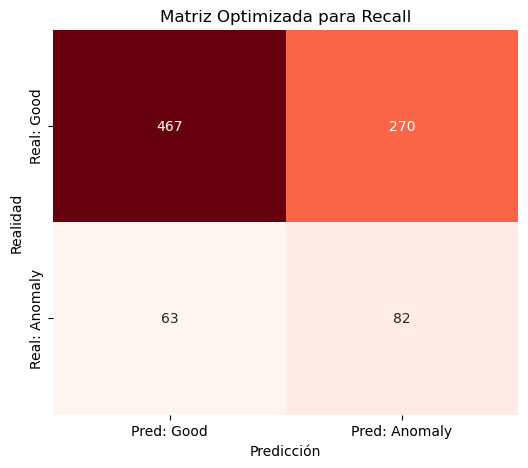

              precision    recall  f1-score   support

        Good       0.88      0.63      0.74       737
     Anomaly       0.23      0.57      0.33       145

    accuracy                           0.62       882
   macro avg       0.56      0.60      0.53       882
weighted avg       0.77      0.62      0.67       882


⚠️ DEJAMOS ESCAPAR: 63 de 145 defectos.


In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. APLANAR SI ES NECESARIO ---
if len(X_train.shape) > 2:
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_val_flat   = X_val.reshape(len(X_val), -1)
    X_test_flat  = X_test.reshape(len(X_test), -1)
else:
    X_train_flat, X_val_flat, X_test_flat = X_train, X_val, X_test

# --- 2. CONFIGURACIÓN ---
param_grid = {
    # Probamos contaminaciones más altas para forzar al modelo a detectar más
    'contamination': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], 
    'n_estimators': [100, 200],      
    'max_features': [1.0, 0.8]       
}

best_score = 0
best_params = {}
best_model = None

# --- 3. BUCLE DE BÚSQUEDA (OPTIMIZANDO RECALL) ---
print("🚀 Buscando el modelo que NO deje pasar anomalías (Max Recall)...")

for cont in param_grid['contamination']:
    for n_est in param_grid['n_estimators']:
        for max_feat in param_grid['max_features']:
            
            # Entrenar
            clf = IsolationForest(contamination=cont, 
                                  n_estimators=n_est, 
                                  max_features=max_feat,
                                  random_state=42, 
                                  n_jobs=-1)
            clf.fit(X_train_flat)
            
            # Evaluar en VAL
            preds_raw = clf.predict(X_val_flat)
            preds_val = [1 if x == -1 else 0 for x in preds_raw]
            
            # --- CAMBIO CLAVE: USAMOS RECALL ---
            # Nos da igual la precisión, queremos cazar todas las anomalías
            current_recall = recall_score(y_val, preds_val, pos_label=1)
            
            # Si el recall es mejor, guardamos este modelo
            if current_recall > best_score:
                best_score = current_recall
                best_params = {'contamination': cont, 'n_estimators': n_est, 'max_features': max_feat}
                best_model = clf
            
            print(f"Params: {cont}, {n_est}, {max_feat} -> Recall Val: {current_recall:.2%}")

print("-" * 40)
print(f"🏆 MEJOR MODELO (Maximizando Recall)")
print(f"   Parámetros: {best_params}")
print(f"   Recall en Val: {best_score:.2%}")
print("-" * 40)

# --- 4. PRUEBA DE FUEGO EN TEST ---
if best_model:
    print("\n📝 Resultados finales en TEST:")
    preds_test_raw = best_model.predict(X_test_flat)
    preds_test = [1 if x == -1 else 0 for x in preds_test_raw]
    
    # Matriz
    cm = confusion_matrix(y_test, preds_test)
    
    plt.figure(figsize=(6, 5))
    # Usamos mapa de color rojo para enfatizar el peligro de los fallos
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=['Pred: Good', 'Pred: Anomaly'],
                yticklabels=['Real: Good', 'Real: Anomaly'])
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.title('Matriz Optimizada para Recall')
    plt.show()
    
    # Métricas
    print(classification_report(y_test, preds_test, target_names=['Good', 'Anomaly']))
    
    # Dato clave para ti
    fallos_graves = cm[1, 0] # Anomalías que el modelo dijo que eran buenas
    total_anomalias = cm[1, 0] + cm[1, 1]
    print(f"\n⚠️ DEJAMOS ESCAPAR: {fallos_graves} de {total_anomalias} defectos.")

## Random Forest

Aplanando datos para Random Forest...
Entrenando con 4114 muestras y 4096 características.
🚀 Iniciando búsqueda de hiperparámetros (esto puede tardar unos minutos)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

🏆 MEJOR MODELO ENCONTRADO
   Parámetros: {'class_weight': {0: 1, 1: 20}, 'max_depth': 20, 'n_estimators': 100}
   Recall en Validación (CV): 51.26%

📝 Evaluando en el Test Set...


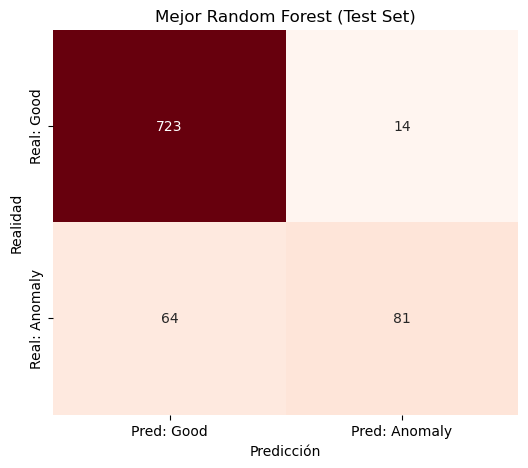

              precision    recall  f1-score   support

        Good       0.92      0.98      0.95       737
     Anomaly       0.85      0.56      0.68       145

    accuracy                           0.91       882
   macro avg       0.89      0.77      0.81       882
weighted avg       0.91      0.91      0.90       882


🔍 RESUMEN FINAL:
De 145 telas defectuosas, el modelo atrapó 81.
Se escaparon 64 defectos.
❌ Todavía se escapan demasiados defectos. Necesitamos Deep Learning.


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. APLANAR DATOS (Si no están planos ya) ---
# Random Forest necesita matriz 2D
if len(X_train.shape) > 2:
    print("Aplanando datos para Random Forest...")
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat  = X_test.reshape(len(X_test), -1)
else:
    X_train_flat, X_test_flat = X_train, X_test

print(f"Entrenando con {X_train_flat.shape[0]} muestras y {X_train_flat.shape[1]} características.")

# --- 2. DEFINIR LA REJILLA DE PARÁMETROS ---
param_grid = {
    # Número de árboles
    'n_estimators': [100, 200],
    
    # Profundidad máxima (None = crece hasta el final, números = poda el árbol)
    'max_depth': [None, 20, 50],
    
    # PESOS: Aquí está la clave.
    # 'balanced': Ajusta pesos inversamente proporcionales a las frecuencias.
    # {0: 1, 1: 10}: Un error en Anomaly(1) cuesta 10 veces más que en Good(0).
    # {0: 1, 1: 20}: Un error en Anomaly(1) cuesta 20 veces más (Muy agresivo).
    'class_weight': ['balanced', {0: 1, 1: 10}, {0: 1, 1: 20}]
}

# --- 3. CONFIGURAR EL GRID SEARCH ---
print("🚀 Iniciando búsqueda de hiperparámetros (esto puede tardar unos minutos)...")

# Usamos scoring='recall' para que elija el modelo que mejor detecta anomalías
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall', # <--- OPTIMIZAMOS PARA RECALL (Sensibilidad)
    cv=3,             # Cross-Validation de 3 pliegues
    n_jobs=-1,        # Usar todos los núcleos
    verbose=2         # Para ver el progreso
)

# Entrenamos con el set de Train
grid_search.fit(X_train_flat, y_train)

# --- 4. RESULTADOS DEL GRID SEARCH ---
best_rf = grid_search.best_estimator_
print("\n" + "="*40)
print(f"🏆 MEJOR MODELO ENCONTRADO")
print(f"   Parámetros: {grid_search.best_params_}")
print(f"   Recall en Validación (CV): {grid_search.best_score_:.2%}")
print("="*40)

# --- 5. EVALUACIÓN FINAL EN TEST ---
print("\n📝 Evaluando en el Test Set...")

preds = best_rf.predict(X_test_flat)

# Matriz de Confusión
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Mejor Random Forest (Test Set)')
plt.show()

# Reporte
print(classification_report(y_test, preds, target_names=['Good', 'Anomaly']))

# Análisis de fallos
fallos_graves = cm[1, 0] # Anomalías reales que predijo como Good
total_defectos = cm[1, 0] + cm[1, 1]

print(f"\n🔍 RESUMEN FINAL:")
print(f"De {total_defectos} telas defectuosas, el modelo atrapó {cm[1, 1]}.")
print(f"Se escaparon {fallos_graves} defectos.")

if fallos_graves == 0:
    print("✅ ¡PERFECTO! Recall del 100%.")
elif fallos_graves < total_defectos * 0.05:
    print("⚠️ Resultado muy bueno (menos del 5% de fugas).")
else:
    print("❌ Todavía se escapan demasiados defectos. Necesitamos Deep Learning.")

## Extracción de características
Definimos una función para extraer características con LBP, HOG o ambas

In [6]:
from skimage.feature import local_binary_pattern, hog
import numpy as np

def extraer_caracteristicas(imagenes, usar_lbp=True, usar_hog=True):
    features_list = []
    
    print(f"⚙️ Extrayendo características (LBP={usar_lbp}, HOG={usar_hog})...")
    
    # Parámetros LBP
    radius = 3
    n_points = 8 * radius # 24 puntos
    method = 'uniform'
    
    # --- CORRECCIÓN CLAVE ---
    # El número de patrones posibles en método 'uniform' es n_points + 2
    # Fijamos esto como constante para que todos los vectores midan lo mismo.
    n_bins_fijo = int(n_points + 2) 
    
    for i, img in enumerate(imagenes):
        # Asegurarnos de que es 2D (quitamos canales si existen)
        if len(img.shape) == 3:
            img = img.squeeze()
            
        vector_final = []
        
        # --- 1. LBP (Textura Fina) ---
        if usar_lbp:
            lbp = local_binary_pattern(img, n_points, radius, method)
            
            # Usamos el n_bins_fijo y el range fijo
            hist_lbp, _ = np.histogram(lbp.ravel(), 
                                       bins=n_bins_fijo, 
                                       range=(0, n_bins_fijo), 
                                       density=True)
            
            vector_final.extend(hist_lbp)
            
        # --- 2. HOG (Forma y Bordes) ---
        if usar_hog:
            # HOG ya devuelve siempre el mismo tamaño si la imagen de entrada es igual
            fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
            vector_final.extend(fd)
            
        features_list.append(vector_final)
        
        if i > 0 and i % 2000 == 0:
            print(f"   --> Procesadas {i} imágenes...")
            
    return np.array(features_list)

In [7]:
print("--- 1. GENERANDO DATASET SOLO LBP ---")
X_train_lbp = extraer_caracteristicas(X_train, usar_lbp=True, usar_hog=False)
X_test_lbp  = extraer_caracteristicas(X_test,  usar_lbp=True, usar_hog=False)

print("\n--- 2. GENERANDO DATASET SOLO HOG ---")
X_train_hog = extraer_caracteristicas(X_train, usar_lbp=False, usar_hog=True)
X_test_hog  = extraer_caracteristicas(X_test,  usar_lbp=False, usar_hog=True)

print("\n--- 3. GENERANDO DATASET MIXTO (LBP + HOG) ---")
# Concatenamos los dos anteriores para ahorrar tiempo de cálculo
X_train_mix = np.hstack((X_train_lbp, X_train_hog))
X_test_mix  = np.hstack((X_test_lbp,  X_test_hog))

print(f"\nDimensiones finales:")
print(f"LBP Features: {X_train_lbp.shape[1]}")
print(f"HOG Features: {X_train_hog.shape[1]}")
print(f"MIX Features: {X_train_mix.shape[1]}")

--- 1. GENERANDO DATASET SOLO LBP ---
⚙️ Extrayendo características (LBP=True, HOG=False)...
   --> Procesadas 2000 imágenes...
   --> Procesadas 4000 imágenes...
⚙️ Extrayendo características (LBP=True, HOG=False)...

--- 2. GENERANDO DATASET SOLO HOG ---
⚙️ Extrayendo características (LBP=False, HOG=True)...
   --> Procesadas 2000 imágenes...
   --> Procesadas 4000 imágenes...
⚙️ Extrayendo características (LBP=False, HOG=True)...

--- 3. GENERANDO DATASET MIXTO (LBP + HOG) ---

Dimensiones finales:
LBP Features: 26
HOG Features: 1764
MIX Features: 1790



🚀 INICIANDO EXPERIMENTO: SOLO LBP
Fitting 3 folds for each of 12 candidates, totalling 36 fits

🏆 Mejor configuración (SOLO LBP): {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100}

📊 RESULTADOS TEST SET (SOLO LBP):
   Recall (Tasa de detección): 56.55%
   Defectos reales totales:    145
   Defectos detectados:        82
   ❌ DEFECTOS ESCAPADOS:      63


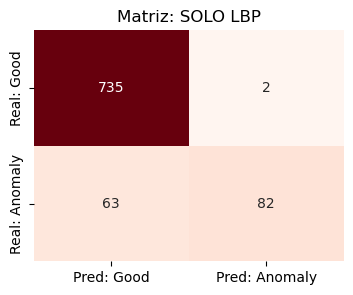


🚀 INICIANDO EXPERIMENTO: SOLO HOG
Fitting 3 folds for each of 12 candidates, totalling 36 fits

🏆 Mejor configuración (SOLO HOG): {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100}

📊 RESULTADOS TEST SET (SOLO HOG):
   Recall (Tasa de detección): 40.00%
   Defectos reales totales:    145
   Defectos detectados:        58
   ❌ DEFECTOS ESCAPADOS:      87


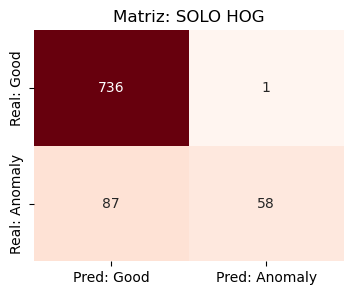


🚀 INICIANDO EXPERIMENTO: MIX (LBP + HOG)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

🏆 Mejor configuración (MIX (LBP + HOG)): {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100}

📊 RESULTADOS TEST SET (MIX (LBP + HOG)):
   Recall (Tasa de detección): 40.00%
   Defectos reales totales:    145
   Defectos detectados:        58
   ❌ DEFECTOS ESCAPADOS:      87


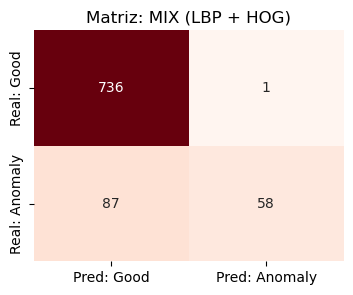



🏁 RESUMEN FINAL DE RECALL:
LBP: 56.55%
HOG: 40.00%
MIX: 40.00%


In [8]:
def entrenar_y_evaluar(nombre_experimento, X_tr, y_tr, X_te, y_te):
    print(f"\n{'='*60}")
    print(f"🚀 INICIANDO EXPERIMENTO: {nombre_experimento}")
    print(f"{'='*60}")
    
    # 1. Parámetros a probar
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 20],
        # Pesos agresivos para priorizar anomalías
        'class_weight': ['balanced', {0: 1, 1: 10}, {0: 1, 1: 20}]
    }
    
    # 2. Grid Search optimizado para RECALL
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid,
        scoring='recall', # ¡Importante!
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_tr, y_tr)
    
    # 3. Mejor Modelo
    best_rf = grid.best_estimator_
    print(f"\n🏆 Mejor configuración ({nombre_experimento}): {grid.best_params_}")
    
    # 4. Evaluación en Test
    preds = best_rf.predict(X_te)
    
    # Métricas
    cm = confusion_matrix(y_te, preds)
    recall = recall_score(y_te, preds)
    total_anomalias = cm[1,0] + cm[1,1]
    escapadas = cm[1,0]
    
    print(f"\n📊 RESULTADOS TEST SET ({nombre_experimento}):")
    print(f"   Recall (Tasa de detección): {recall:.2%}")
    print(f"   Defectos reales totales:    {total_anomalias}")
    print(f"   Defectos detectados:        {cm[1,1]}")
    print(f"   ❌ DEFECTOS ESCAPADOS:      {escapadas}")
    
    # Visualizar Matriz pequeña
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=['Pred: Good', 'Pred: Anomaly'],
                yticklabels=['Real: Good', 'Real: Anomaly'])
    plt.title(f'Matriz: {nombre_experimento}')
    plt.show()
    
    return recall

# --- EJECUTAR LOS 3 EXPERIMENTOS ---

# 1. Solo LBP (Textura)
recall_lbp = entrenar_y_evaluar("SOLO LBP", X_train_lbp, y_train, X_test_lbp, y_test)

# 2. Solo HOG (Forma)
recall_hog = entrenar_y_evaluar("SOLO HOG", X_train_hog, y_train, X_test_hog, y_test)

# 3. Mezcla (Textura + Forma)
recall_mix = entrenar_y_evaluar("MIX (LBP + HOG)", X_train_mix, y_train, X_test_mix, y_test)

print("\n\n🏁 RESUMEN FINAL DE RECALL:")
print(f"LBP: {recall_lbp:.2%}")
print(f"HOG: {recall_hog:.2%}")
print(f"MIX: {recall_mix:.2%}")

Vemos que con estracción de características, hasta empeora el resultado. Puede tener sentido porque por ejmplo en los histogramas de LBP las anomalías que hay en la tela es un porcentaje tan pequeño de la imagen que resulta inapreciable, además de que pierde la información espacial de la imagen.